# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether or not a person will default on their bank loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 


#### Data Set Information:

This research aimed at the case of customers default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default. With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default. 

- NT is the abbreviation for New Taiwain. 


#### Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 = the repayment status in September, 2005; 
    - X7 = the repayment status in August, 2005; . . .;
    - etc...
    - X11 = the repayment status in April, 2005. 
    - The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). 
    - X12 = amount of bill statement in September, 2005;
    - etc...
    - X13 = amount of bill statement in August, 2005; . . .; 
    - X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). 
    - X18 = amount paid in September, 2005; 
    - X19 = amount paid in August, 2005; . . .;
    - etc...
    - X23 = amount paid in April, 2005. 




You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) to predict credit card defaults and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

- You will be working in pairs for this assessment

### Please have ONE notebook and be prepared to explain how you worked in your pair.

1. Clean up your data set so that you can perform an EDA. 
    - This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Engineer new features. 
    - Create polynomial and/or interaction features. 
    - Additionaly, you must also create **at least 2 new features** that are not interactions or polynomial transformations. 
        - *For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.*
4. Perform some feature selection. 
    
5. You must fit **three** models to your data and tune **at least 1 hyperparameter** per model. 
6. Using the F-1 Score, evaluate how well your models perform and identify your best model.
7. Using information from your EDA process and your model(s) output provide insight as to which borrowers are more likely to deafult


In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

import xgboost as xgb

pd.options.display.max_columns =25
pd.options.display.max_rows = 100

## 1. Data Cleaning
**Read in data and select column headers**

In [60]:
df = pd.read_csv('data/training_data.csv')

#Row 18381 contains column names
df.columns = df.iloc[18381]
df.columns = df.columns.str.replace(" ","_")
df.drop(labels=[18381],axis=0,inplace=True)
df.drop(columns=['ID'],inplace=True)
df.rename(columns={'PAY_0':'PAY_1','default_payment_next_month':'default'},inplace=True)
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object', name=18381)

**Set datatypes**

In [34]:
#set d types as int
for col in df.columns:
    df[col] = pd.to_numeric(df[col])
df.info() #no np.nan

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22499 entries, 0 to 22499
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  22499 non-null  int64
 1   SEX        22499 non-null  int64
 2   EDUCATION  22499 non-null  int64
 3   MARRIAGE   22499 non-null  int64
 4   AGE        22499 non-null  int64
 5   PAY_1      22499 non-null  int64
 6   PAY_2      22499 non-null  int64
 7   PAY_3      22499 non-null  int64
 8   PAY_4      22499 non-null  int64
 9   PAY_5      22499 non-null  int64
 10  PAY_6      22499 non-null  int64
 11  BILL_AMT1  22499 non-null  int64
 12  BILL_AMT2  22499 non-null  int64
 13  BILL_AMT3  22499 non-null  int64
 14  BILL_AMT4  22499 non-null  int64
 15  BILL_AMT5  22499 non-null  int64
 16  BILL_AMT6  22499 non-null  int64
 17  PAY_AMT1   22499 non-null  int64
 18  PAY_AMT2   22499 non-null  int64
 19  PAY_AMT3   22499 non-null  int64
 20  PAY_AMT4   22499 non-null  int64
 21  PAY_AMT5   2

**Checking for other kinds of missing values**

Map education values not in dictionary to 4 indicating "other" education

In [35]:
conditions = [df.EDUCATION == 0,
             df.EDUCATION == 6,
             df.EDUCATION == 5]

choices = [4,4,4]

df.EDUCATION = np.select(conditions,choices,default=df.EDUCATION)


Map marriage values not in dictionary to 3 indicating "other" marital status

In [36]:
df.MARRIAGE = np.where(df.MARRIAGE ==0,3,df.MARRIAGE)
df.MARRIAGE.value_counts()

2    12026
1    10195
3      278
Name: MARRIAGE, dtype: int64

**Check for duplicates**

In [37]:
df.duplicated().sum() #no duplicates

23

## 2. EDA

In [418]:
df.describe()

18381,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,2.249900e+04,22499.000000,22499.000000,22499.000000,22499.000000,2.249900e+04,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000
mean,14951.920308,167054.521534,1.603227,1.844260,1.559225,35.447931,-0.014090,-0.128806,-0.160185,-0.214587,-0.259700,-0.287613,51455.869416,49385.313214,4.704213e+04,43329.149562,40306.373039,38955.000356,5627.914796,5.964393e+03,5258.912307,4792.971777,4865.656029,5247.279301,0.223477
std,8663.502421,129864.960118,0.489239,0.745099,0.520785,9.237634,1.123191,1.197954,1.198880,1.174824,1.139984,1.154249,74470.257248,71953.814345,6.991792e+04,64607.088483,60918.993067,59773.144959,16628.162287,2.444370e+04,18153.554633,15872.858180,15507.449610,17892.327398,0.416584
min,1.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-81334.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7419.500000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3506.000000,2975.000000,2.611500e+03,2319.500000,1732.500000,1230.000000,1000.000000,8.290000e+02,396.000000,284.000000,246.500000,100.000000,0.000000
50%,14947.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22387.000000,21145.000000,2.005300e+04,19048.000000,18050.000000,16924.000000,2100.000000,2.004000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,22441.000000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66988.500000,63755.000000,6.016100e+04,54494.500000,50196.000000,49250.000000,5002.000000,5.000000e+03,4500.000000,4000.000000,4068.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,388071.000000,528666.000000,1.000000


0    17471
1     5028
Name: default, dtype: int64
0    0.776523
1    0.223477
Name: default, dtype: float64


<BarContainer object of 2 artists>

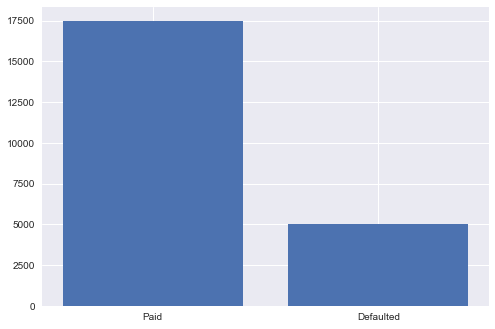

In [419]:
#how many people default?
print(y.value_counts())
print(y.value_counts(normalize=True))
plt.style.use('seaborn')
plt.bar(['Paid','Defaulted'],y.value_counts())


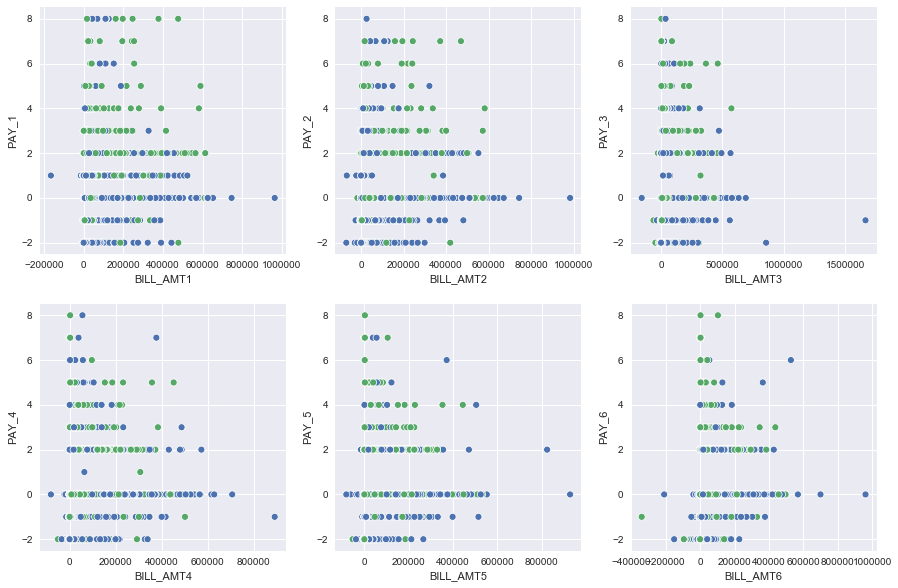

In [420]:
#looking at demographic pair plots
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10))

for i in range(6):
    sns.scatterplot(df[f'BILL_AMT{i+1}'],df[f'PAY_{i+1}'],ax=ax[i//3][i%3],
                    hue=df['default'],legend=False)

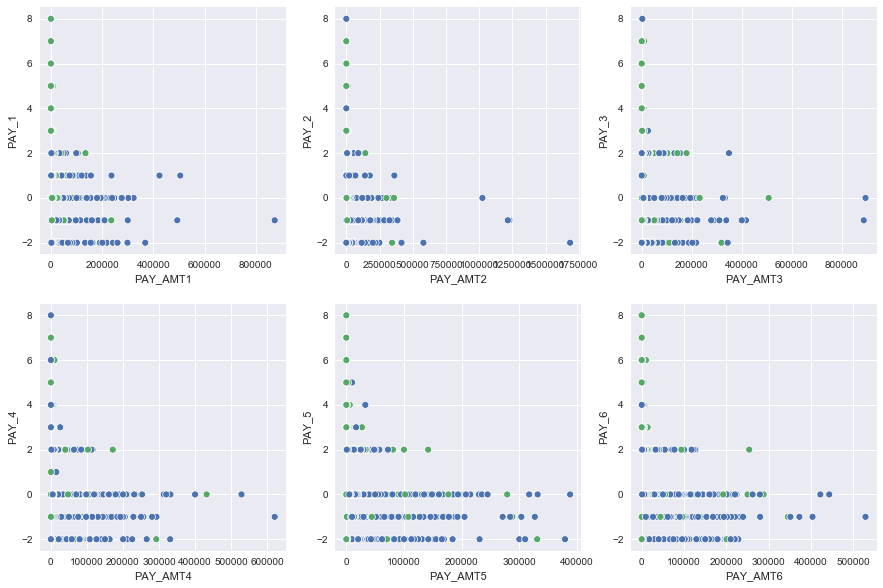

In [421]:
#looking at demographic pair plots
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10))

for i in range(6):
    sns.scatterplot(df[f'PAY_AMT{i+1}'],df[f'PAY_{i+1}'],ax=ax[i//3][i%3],
                    hue=df['default'],legend=False,x_jitter=True)

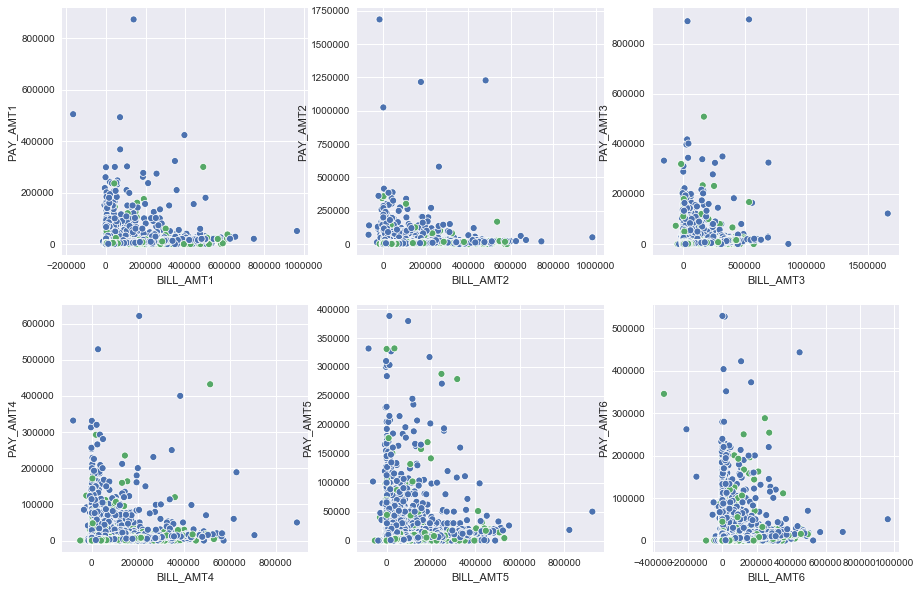

In [422]:
#looking at demographic pair plots
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10))

for i in range(6):
    sns.scatterplot(df[f'BILL_AMT{i+1}'],df[f'PAY_AMT{i+1}'],ax=ax[i//3][i%3],
                    hue=df['default'],legend=False)

In [423]:
#high class imbalance in Sex 60% of dataset is female
print(df.SEX.value_counts())
print(df.SEX.value_counts(normalize=True))

2    13572
1     8927
Name: SEX, dtype: int64
2    0.603227
1    0.396773
Name: SEX, dtype: float64


SEX  default
1    0          0.757029
     1          0.242971
2    0          0.789346
     1          0.210654
Name: default, dtype: float64

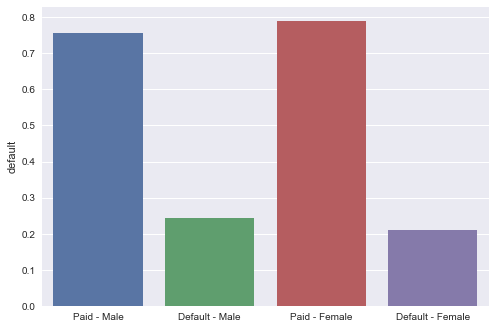

In [424]:
#men have default ratio: ~20% female default, ~25% male default
sns.barplot(['Paid - Male','Default - Male','Paid - Female','Default - Female'],
        df.groupby('SEX').default.value_counts(normalize=True))

df.groupby('SEX').default.value_counts(normalize=True)

In [425]:
#other and high school are much smaller populations than grad school and university
print(df.groupby('EDUCATION').default.value_counts())
print(df.groupby('EDUCATION').default.value_counts(normalize=True))


EDUCATION  default
1          0          6388
           1          1531
2          0          7998
           1          2518
3          0          2764
           1           949
4          0           321
           1            30
Name: default, dtype: int64
EDUCATION  default
1          0          0.806668
           1          0.193332
2          0          0.760555
           1          0.239445
3          0          0.744412
           1          0.255588
4          0          0.914530
           1          0.085470
Name: default, dtype: float64


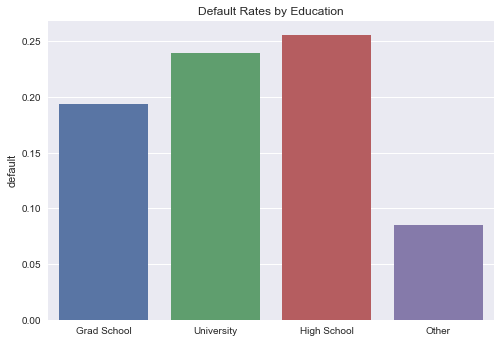

In [426]:
#less schooling, higher rate of default
sns.barplot(['Grad School','University','High School','Other'],
            df.groupby('EDUCATION').default.value_counts(normalize=True).loc[pd.IndexSlice[:,[1]]]
           )

plt.title('Default Rates by Education');

In [427]:
df.groupby('MARRIAGE').default.value_counts(normalize=True)

MARRIAGE  default
1         0          0.762138
          1          0.237862
2         0          0.787876
          1          0.212124
3         0          0.812950
          1          0.187050
Name: default, dtype: float64

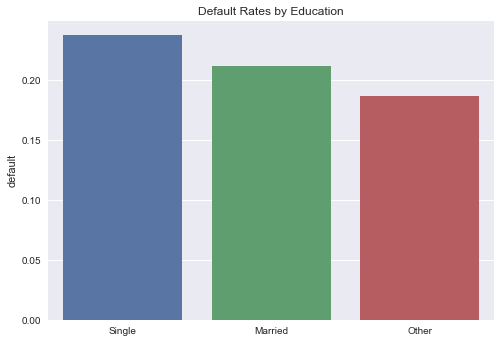

In [428]:
#marital status other than single, lower default rate
sns.barplot(['Single','Married','Other'],
            df.groupby('MARRIAGE').default.value_counts(normalize=True).loc[pd.IndexSlice[:,[1]]]
           )

plt.title('Default Rates by Education');

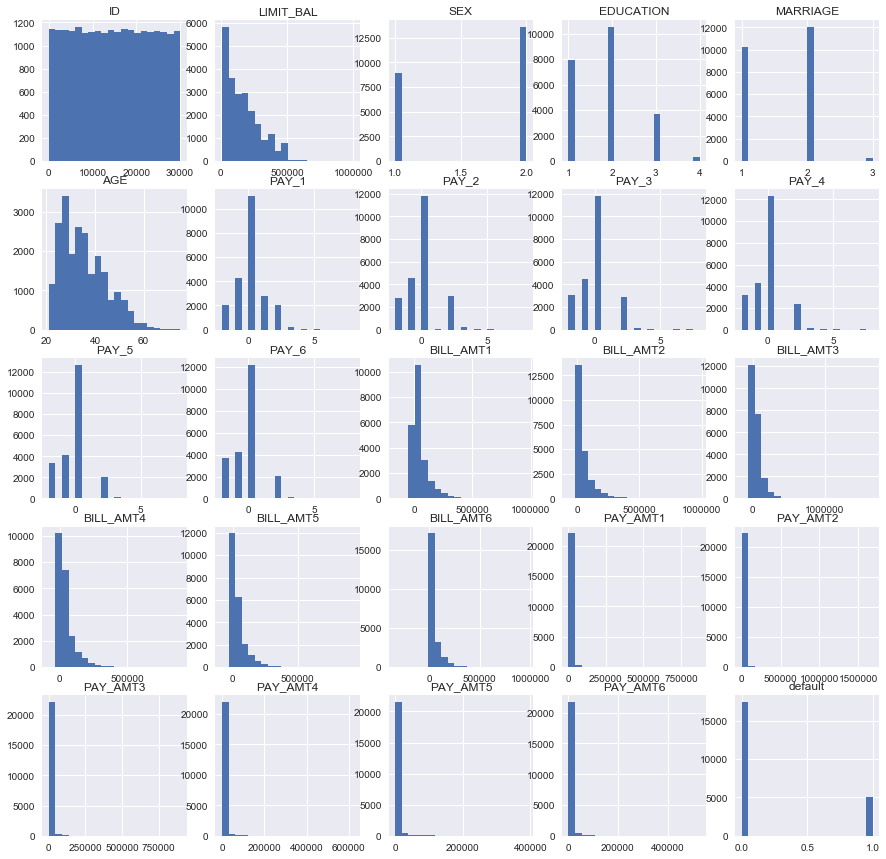

In [429]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=(15,15))

# sns.distplot(df.ID)

for i, col in enumerate(df.columns):
    df[col].hist(ax=ax[i//5][i%5],bins=20)
    ax[i//5][i%5].set_title(col)

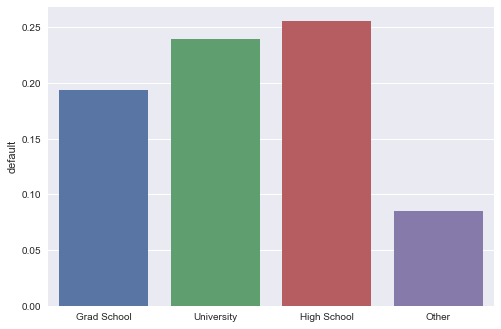

In [430]:
sns.barplot(['Grad School','University','High School','Other'],
            df.groupby('EDUCATION').default.value_counts(normalize=True).loc[pd.IndexSlice[:,[1]]]
           )

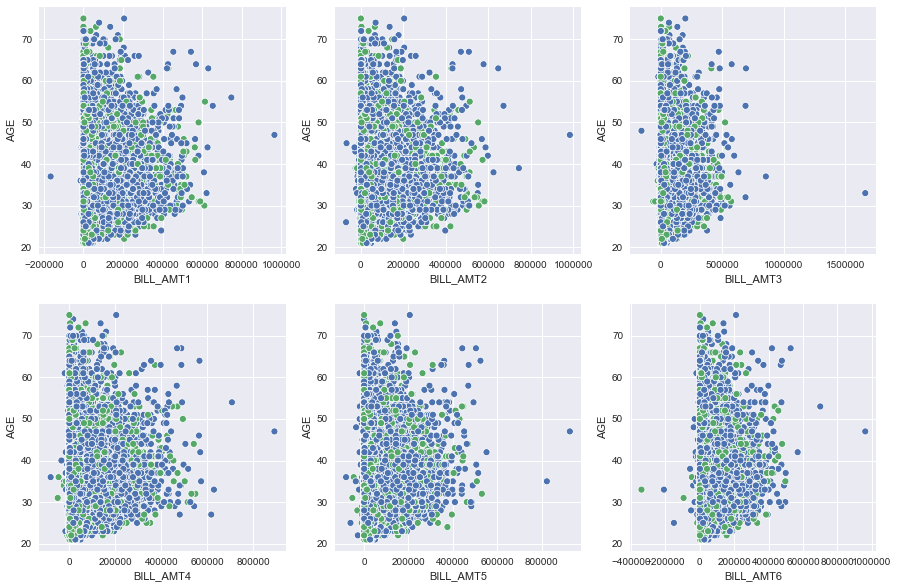

In [431]:
#Age vs Bill
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10))

for i in range(6):
    sns.scatterplot(df[f'BILL_AMT{i+1}'],df['AGE'],ax=ax[i//3][i%3],
                    hue=df['default'],legend=False)

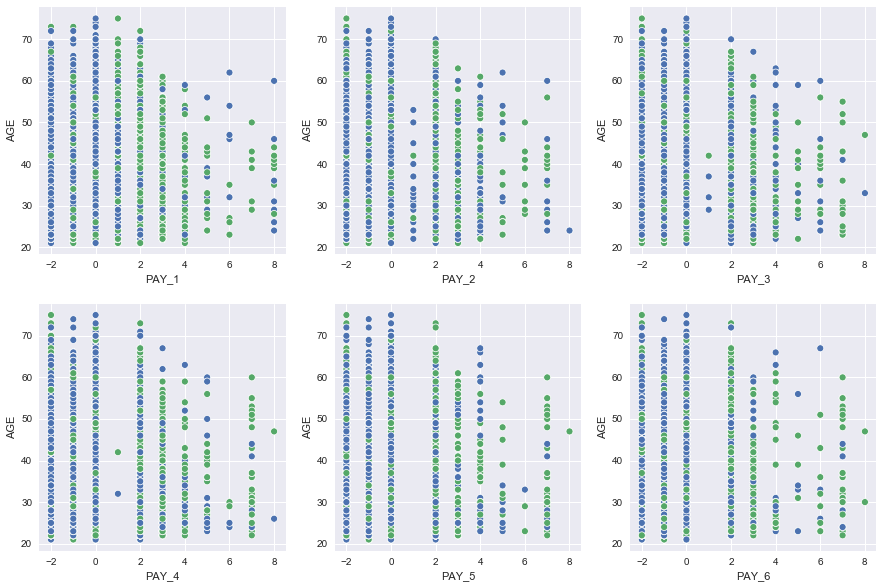

In [432]:
#Age vs Pay
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10))

for i in range(6):
    sns.scatterplot(df[f'PAY_{i+1}'],df['AGE'],ax=ax[i//3][i%3],
                    hue=df['default'],legend=False)

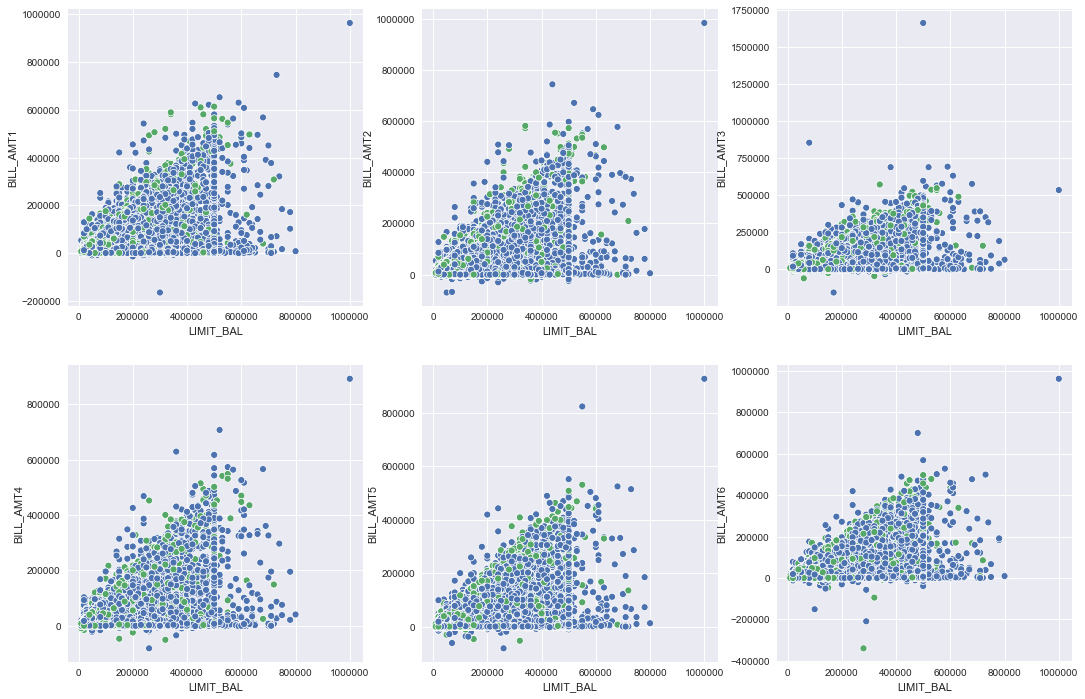

In [433]:
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(18,12))

for i in range(6):
    sns.scatterplot(df.LIMIT_BAL,df[f'BILL_AMT{i+1}'],ax=ax[i//3][i%3],
                    hue=df['default'],legend=False)

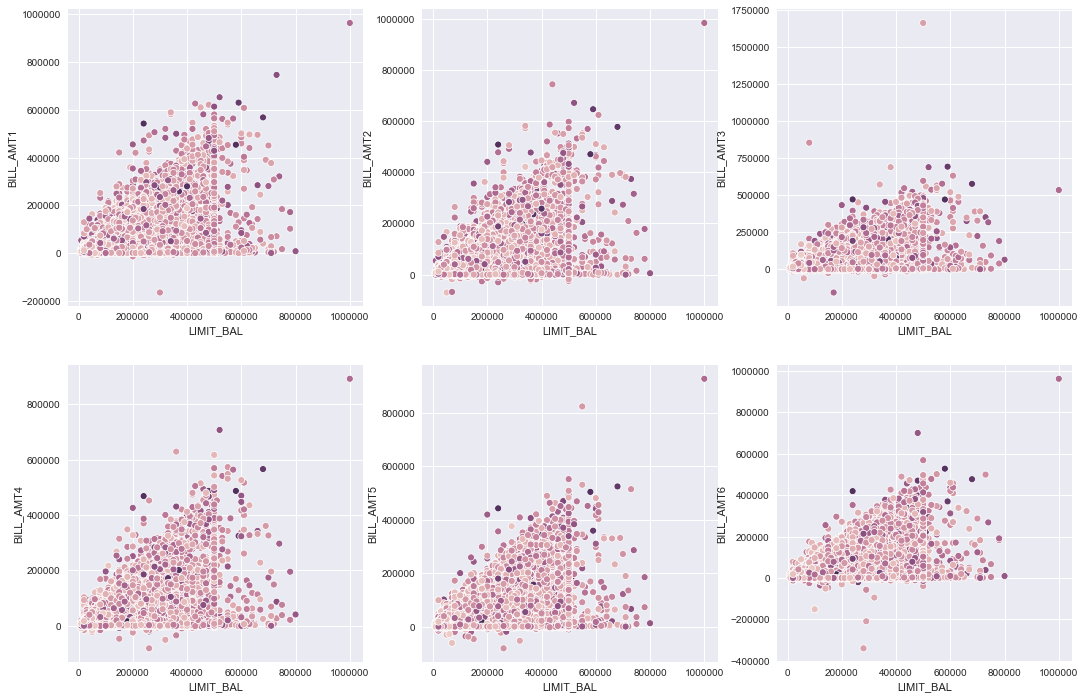

In [434]:
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(18,12))

for i in range(6):
    sns.scatterplot(df.LIMIT_BAL,df[f'BILL_AMT{i+1}'],ax=ax[i//3][i%3],
                    hue=df['AGE'],legend=False)

In [435]:
df.describe()

18381,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,2.249900e+04,22499.000000,22499.000000,22499.000000,22499.000000,2.249900e+04,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000
mean,14951.920308,167054.521534,1.603227,1.844260,1.559225,35.447931,-0.014090,-0.128806,-0.160185,-0.214587,-0.259700,-0.287613,51455.869416,49385.313214,4.704213e+04,43329.149562,40306.373039,38955.000356,5627.914796,5.964393e+03,5258.912307,4792.971777,4865.656029,5247.279301,0.223477
std,8663.502421,129864.960118,0.489239,0.745099,0.520785,9.237634,1.123191,1.197954,1.198880,1.174824,1.139984,1.154249,74470.257248,71953.814345,6.991792e+04,64607.088483,60918.993067,59773.144959,16628.162287,2.444370e+04,18153.554633,15872.858180,15507.449610,17892.327398,0.416584
min,1.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-81334.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7419.500000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3506.000000,2975.000000,2.611500e+03,2319.500000,1732.500000,1230.000000,1000.000000,8.290000e+02,396.000000,284.000000,246.500000,100.000000,0.000000
50%,14947.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22387.000000,21145.000000,2.005300e+04,19048.000000,18050.000000,16924.000000,2100.000000,2.004000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,22441.000000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66988.500000,63755.000000,6.016100e+04,54494.500000,50196.000000,49250.000000,5002.000000,5.000000e+03,4500.000000,4000.000000,4068.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,388071.000000,528666.000000,1.000000


0        3905
2000     1012
3000      682
5000      539
1500      394
         ... 
4940        1
11005       1
21250       1
2879        1
6187        1
Name: PAY_AMT1, Length: 6630, dtype: int64


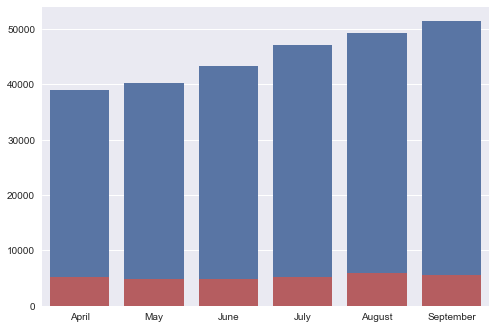

In [436]:
#looks like most people just pay the minimum
mean_bill = [df[f'BILL_AMT{i+1}'].mean() for i in range(6)]
mean_pay = [df[f'PAY_AMT{i+1}'].mean() for i in range(6)]

sns.set_color_codes()

sns.barplot(['April','May','June','July','August','September'],mean_bill[::-1],color='b')
sns.barplot(['April','May','June','July','August','September'],mean_pay[::-1],color='r')
print(df.PAY_AMT1.value_counts())

## 3. Handling Outliers & Feature Engineering

**Handling Major Outliers**

In [38]:
for i in range(6):
    df[f'BILL_AMT{i+1}'] = np.where(df[f'BILL_AMT{i+1}'] > df[f'BILL_AMT{i+1}'].quantile(.99),
                                    df[f'BILL_AMT{i+1}'].quantile(.99),
                                    df[f'BILL_AMT{i+1}']
                                   )
    df[f'PAY_AMT{i+1}'] = np.where(df[f'PAY_AMT{i+1}'] > df[f'PAY_AMT{i+1}'].quantile(.99),
                                    df[f'PAY_AMT{i+1}'].quantile(.99),
                                    df[f'PAY_AMT{i+1}']
                                   )

df.LIMIT_BAL = np.where(df.LIMIT_BAL > df.LIMIT_BAL.quantile(.99),
                        df.LIMIT_BAL.quantile(.99),
                       df.LIMIT_BAL)

In [39]:
df.describe()

18381,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000
mean,166382.047202,1.603227,1.844260,1.559225,35.447931,-0.014090,-0.128806,-0.160185,-0.214587,-0.259700,-0.287613,50607.711276,48545.099316,46140.418885,42531.388284,39585.760900,38235.055269,5011.428775,5111.506511,4557.780968,4198.229455,4259.925374,4609.746433,0.223477
std,127707.427930,0.489239,0.745099,0.520785,9.237634,1.123191,1.197954,1.198880,1.174824,1.139984,1.154249,69998.985706,67484.610065,64621.791555,60266.977194,56941.084467,55839.466027,9387.741142,10381.022516,9518.047610,9222.306669,9295.487167,11287.948741,0.416584
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-157264.000000,-81334.000000,-81334.000000,-339603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3506.000000,2975.000000,2611.500000,2319.500000,1732.500000,1230.000000,1000.000000,829.000000,396.000000,284.000000,246.500000,100.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22387.000000,21145.000000,20053.000000,19048.000000,18050.000000,16924.000000,2100.000000,2004.000000,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66988.500000,63755.000000,60161.000000,54494.500000,50196.000000,49250.000000,5002.000000,5000.000000,4500.000000,4000.000000,4068.500000,4000.000000,0.000000
max,500000.000000,2.000000,4.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,354308.040000,341601.140000,325774.340000,305263.480000,288711.220000,279508.300000,66030.960000,77000.000000,69005.880000,67302.260000,67006.360000,84433.960000,1.000000


Percentage Use

In [40]:
for i in range(6):
    df[f'percent_use{i+1}'] = df[f'BILL_AMT{i+1}']/df['LIMIT_BAL']

High limit (>310000 aka 85th quantile) 

In [41]:
df['high_lim'] = np.where(df.LIMIT_BAL > df.LIMIT_BAL.quantile(.85),
                         df.LIMIT_BAL.quantile(.85),
                         df.LIMIT_BAL)

Late or not

In [42]:
for i in range(6):
    df[f'late{i+1}'] = np.where(df[f'PAY_{i+1}'] > 1, 1, 0)

Paid in full

In [43]:
for i in range(6):
    df[f'full{i+1}'] = np.where(df[f'BILL_AMT{i+1}'] - df[f'PAY_AMT{i+1}'] <= 0, 1, 0)

Percentage paid

In [44]:
for i in range(6):
    df[f'percent_pay{i+1}'] = df[f'PAY_AMT{i+1}'] / df[f'BILL_AMT{i+1}']
    df[f'percent_pay{i+1}'] = np.where(df[f'BILL_AMT{i+1}'] <= 0,1,df[f'percent_pay{i+1}'])

Young (<30)

In [45]:
df['young'] = np.where(df.AGE <= 30, 1, 0)

Dummy Variables

In [46]:
df = pd.get_dummies(df,columns=['SEX','EDUCATION','MARRIAGE'],drop_first=True)

In [47]:
df.describe()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,...,percent_pay2,percent_pay3,percent_pay4,percent_pay5,percent_pay6,young,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
count,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,...,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000
mean,166382.047202,35.447931,-0.014090,-0.128806,-0.160185,-0.214587,-0.259700,-0.287613,50607.711276,48545.099316,46140.418885,42531.388284,...,1.518133,1.726631,1.592763,1.124451,1.306248,0.369483,0.603227,0.467399,0.165030,0.015601,0.534513,0.012356
std,127707.427930,9.237634,1.123191,1.197954,1.198880,1.174824,1.139984,1.154249,69998.985706,67484.610065,64621.791555,60266.977194,...,35.844420,58.704633,67.973755,10.970432,15.695360,0.482676,0.489239,0.498947,0.371215,0.123927,0.498819,0.110472
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-157264.000000,-81334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3506.000000,2975.000000,2611.500000,2319.500000,...,0.038806,0.033779,0.032926,0.036185,0.036118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22387.000000,21145.000000,20053.000000,19048.000000,...,0.075476,0.062480,0.052742,0.060804,0.066364,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66988.500000,63755.000000,60161.000000,54494.500000,...,0.800313,0.864791,0.829904,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,500000.000000,75.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,354308.040000,341601.140000,325774.340000,305263.480000,...,4444.333333,6333.333333,8887.666667,692.681818,1600.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Feature Selection

**Features & Target**

In [48]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('default', axis = 1) # grabs everything else but y


# Create target variable
y = df['default'] # y is the column we're trying to predict

**Test Train Split**

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [50]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16874, 52)
(16874,)
(5625, 52)
(5625,)


**Scaling**

In [51]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


**Recursive Feature Elimination**

In [356]:
logreg = LogisticRegression()

selector = RFECV(estimator=logreg, step=1, cv=5, scoring='f1', n_jobs=-1)

selector.fit(X_train,y_train)

selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columnsp[~selector.support_]

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
removed_

## 5. Model Fitting and Hyperparameter Tuning
KNN

In [339]:
knn = KNeighborsClassifier()

grid_params = {
    'n_neighbors': range(3,20,2),
    'weights': ['uniform','distance']
}



knn_grid = GridSearchCV(
    knn,
    grid_params,
    verbose = 1,
    cv = 5,
    n_jobs = -1,
    scoring = 'f1'
)

knn_grid_results = grid.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.6min finished


In [340]:
y_pred_knn = knn_grid_results.best_estimator_.predict(X_test)


print(y_pred.shape)
print(y_test.shape)

(5625,)
(5625,)


In [341]:
print(f"""KNN Results
***************************
Best Model: {knn_grid_results.best_estimator_}
Best Train F1:{knn_grid_results.best_score_}
Best Test F1:{f1_score(y_test,y_pred_knn)}
***************************
""")

KNN Results
***************************
Best Model: KNeighborsClassifier(n_neighbors=9, weights='distance')
Best Train F1:0.45291053934274456
Best Test F1:0.469488188976378
***************************



Logistic Regression

In [342]:
logreg = LogisticRegression(random_state=42)

grid_params = {
    'penalty':['l1','l2'],
    'C':[.25,.5,.75,1,5,10,50,100],
    'class_weight': ['balanced',None]
}

logreg_grid = GridSearchCV(
    logreg, 
    grid_params, 
    scoring='f1',
    cv= 5,
    n_jobs = -1,
    verbose=1
)

logreg_grid_results = logreg_grid.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.7s finished


In [343]:
y_pred_logreg = logreg_grid_results.best_estimator_.predict(X_test)

print(f"""Logistic Regression Results
***************************
Best Model: {logreg_grid_results.best_estimator_}
Best Train F1:{logreg_grid_results.best_score_}
Best Test F1:{f1_score(y_test,y_pred_logreg)}
***************************
""")

Logistic Regression Results
***************************
Best Model: LogisticRegression(C=5, class_weight='balanced', random_state=42)
Best Train F1:0.5217841458630903
Best Test F1:0.5597173144876324
***************************



Decision Tree

In [344]:
dtc = DecisionTreeClassifier(random_state=42,class_weight='balanced')

grid_params = {
    'max_depth': range(2,10,2),
    'min_samples_split': range(5,30,5),
    'max_leaf_nodes': range(15,65,10),
    'max_features': ['auto','sqrt',None]
}

dtc_grid = GridSearchCV(
    dtc,
    grid_params,
    cv = 5,
    verbose = 1,
    n_jobs=-1,
    scoring='f1'
)

dtc_grid_results = dtc_grid.fit(X_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   36.2s finished


In [345]:
y_pred_dtc = dtc_grid_results.best_estimator_.predict(X_test)

print(f"""Decision Tree Results
***************************
Best Model: {dtc_grid_results.best_estimator_}
Best Train F1:{dtc_grid_results.best_score_}
Best Test F1:{f1_score(y_test,y_pred_dtc)}
***************************
""")

Decision Tree Results
***************************
Best Model: DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_leaf_nodes=15,
                       min_samples_split=5, random_state=42)
Best Train F1:0.5140269164938531
Best Test F1:0.5273250239693192
***************************



Ensemble Voting

In [459]:
best_knn = knn_grid_results.best_estimator_
best_logreg = logreg_grid_results.best_estimator_
best_dtc = dtc_grid_results.best_estimator_

voter = VotingClassifier(estimators=[('knn',best_knn),('logreg',best_logreg),('tree',best_dtc)],
                        voting='soft')

voter.fit(X_train,y_train)

y_train_pred = voter.predict(X_train)
y_test_pred = voter.predict(X_test)


print(f"""Voting Results
***************************
Enseble Model: {voter}
Train F1:{f1_score(y_train,y_train_pred)}
Test F1:{f1_score(y_test,y_test_pred)}
***************************
""")

Voting Results
***************************
Enseble Model: VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=9,
                                                   weights='distance')),
                             ('logreg',
                              LogisticRegression(C=5, class_weight='balanced',
                                                 random_state=42)),
                             ('tree',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=4,
                                                     max_leaf_nodes=15,
                                                     min_samples_split=5,
                                                     random_state=42))],
                 voting='soft')
Train F1:0.9062267427437359
Test F1:0.5420482930890924
***************************



Random Forest

In [351]:
forest = RandomForestClassifier(random_state=42,class_weight='balanced')

grid_params = {
    'n_estimators':[50,100,500,1000,5000]
    'max_depth': range(2,10,2),
    'min_samples_split': range(5,30,5),
    'max_leaf_nodes': range(15,65,10),
    'max_features': ['auto','sqrt',None]
    'max_samples': [None,.25,.5,.75,.9]
}

forest_grid = GridSearchCV(
    forest,
    grid_params,
    cv=5,
    verbose=1
    n_jobs=-1
    scoring='f1'
)

forest_grid_results = forest_grid.fit(X_train,y_train)

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 42.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 60.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 70.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 83.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 148.8min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 166.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 195.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks    

In [352]:
y_pred_forest = forest_grid_results.best_estimator_.predict(X_test)

print(f"""Random Forrest Results
***************************
Best Model: {forest_grid_results.best_estimator_}
Best Train F1:{forest_grid_results.best_score_}
Best Test F1:{f1_score(y_test,y_pred_forest)}
***************************
""")

Random Forrest Results
***************************
Best Model: RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=35,
                       max_samples=0.75, min_samples_split=25, random_state=42)
Best Train F1:0.5366200068723923
Best Test F1:0.5607207207207208
***************************



In [353]:
forest_grid_results.best_params_

{'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': 35,
 'max_samples': 0.75,
 'min_samples_split': 25,
 'n_estimators': 100}

XGBoost

In [372]:
data_matrix = xgb.DMatrix(data=X,label=y)

In [375]:
xg_model = xgb.XGBClassifier(objective="binary:logistic")

grid_params = {
    "n_estimators":[100,150,200],
    "colsample_bytree":[.25,.5,.75],
    "learning_rate":[.1,.075,.05,.025,.01],
    "max_depth":range(3,8)
}

xgsearch = GridSearchCV(
    estimator= xg_model,
    param_grid= grid_params,
    scoring = 'f1',
    n_jobs=-1,
    verbose=1,
    cv=5
)

In [381]:
xgsearch.fit(X_train,y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
ERROR:concurrent.futures:exception calling callback for <Future at 0x7ffe53b2e240 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'sklearn.metrics._scorer'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
 

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

## 6. Model Evaluation

In [52]:
best_forest = RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=35,
                       max_samples=0.75, min_samples_split=25, random_state=42)

best_forest.fit(X_train,y_train)

forest_train_f1 = np.mean(cross_val_score(best_forest,X_train,y_train,scoring='f1',cv=10))

forest_test_f1 = f1_score(y_test,best_forest.predict(X_test))

In [53]:
modelf1 = pd.DataFrame({'model':['Random Forrest'],'train_f1':[forest_train_f1],'test_f1':[forest_test_f1]})

In [453]:
best_logreg = LogisticRegression(C=5, class_weight='balanced', random_state=42)

best_logreg.fit(X_train,y_train)

logreg_train_f1 = np.mean(cross_val_score(best_logreg,X_train,y_train,scoring='f1',cv=10))

logreg_test_f1 = f1_score(y_test,best_logreg.predict(X_test))

In [454]:
modelf1.append({'model':'Logistic Regression','train_f1':logreg_train_f1,'test_f1':logreg_test_f1},ignore_index=True) 

,model,train_f1,test_f1
0,Random Forrest,0.533400,0.561037
1,Logistic Regression,0.524185,0.558679


In [455]:
voter.fit(X_train,y_train)

voter_train_f1 = np.mean(cross_val_score(voter,X_train,y_train,scoring='f1',cv=10))

voter_test_f1 = f1_score(y_test,voter.predict(X_test))

modelf1.append({'model':'Voter','train_f1':voter_train_f1,'test_f1':voter_test_f1},ignore_index=True) 


,model,train_f1,test_f1
0,Random Forrest,0.5334,0.561037
1,[Voter],[0.5321038301322019],[0.5595547309833024]


In [461]:
voter2 = VotingClassifier(estimators=[('knn',best_knn),('logreg',best_logreg),('tree',best_dtc),('forest',best_forest)],
                        voting='hard')

voter2.fit(X_train,y_train)

y_train_pred = voter.predict(X_train)
y_test_pred = voter.predict(X_test)


print(f"""Voting Results
***************************
Enseble Model: {voter2}
Train F1:{f1_score(y_train,y_train_pred)}
Test F1:{f1_score(y_test,y_test_pred)}
***************************
""")

Voting Results
***************************
Enseble Model: VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=9,
                                                   weights='distance')),
                             ('logreg',
                              LogisticRegression(C=5, class_weight='balanced',
                                                 random_state=42)),
                             ('tree',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=4,
                                                     max_leaf_nodes=15,
                                                     min_samples_split=5,
                                                     random_state=42)),
                             ('forest',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_dept

## 7. Final Model

In [27]:
import pickle

In [54]:
modelf1

,model,train_f1,test_f1
0,Random Forrest,0.535071,0.563662


In [55]:
best_forest

RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=35,
                       max_samples=0.75, min_samples_split=25, random_state=42)

In [56]:
scaler

StandardScaler()

In [57]:
pickle_out = open('model.pickle','wb')
pickle.dump(best_forest,pickle_out)
pickle_out.close()

In [58]:
pickle_out = open('scaler.pickle','wb')
pickle.dump(scaler,pickle_out)
pickle_out.close()